In [1]:
from rdkit import Chem
from sklearn.model_selection import train_test_split

import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Created by: Jinzhe Zhang, 2021/08/06

# Part I. Get the big picture

To process data, we first need to understand about data. 

I.1

Read csv file download from ChEmBL: https://www.ebi.ac.uk/chembl/g/#search_results/all/query=erbB1

In [2]:
df = pd.read_csv('chembl.csv', sep = ';')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14362 entries, 0 to 14361
Data columns (total 45 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Molecule ChEMBL ID          14362 non-null  object 
 1   Molecule Name               1884 non-null   object 
 2   Molecule Max Phase          14362 non-null  int64  
 3   Molecular Weight            14362 non-null  object 
 4   #RO5 Violations             14362 non-null  object 
 5   AlogP                       14362 non-null  object 
 6   Compound Key                14362 non-null  object 
 7   Smiles                      14330 non-null  object 
 8   Standard Type               14362 non-null  object 
 9   Standard Relation           13038 non-null  object 
 10  Standard Value              13035 non-null  float64
 11  Standard Units              13035 non-null  object 
 12  pChEMBL Value               10005 non-null  float64
 13  Data Validity Comment       355

I.2

Although we have 44 different attributes, there are only a few needed our attention. 

For example, we need to check if the target protein and the target organism are what we are looking for.

In [4]:
df['Target Name'].value_counts()

Epidermal growth factor receptor erbB1    14362
Name: Target Name, dtype: int64

In [5]:
df['Target Organism'].value_counts()

Homo sapiens    14362
Name: Target Organism, dtype: int64

I.3

We have also noticed that there are empty values in Standard Value (which is ic50, the property that we are interested in). Related to this study, if any of SMILES, Standard Value or Standard Units is missing, we would not be able to use the data, so we drop these lines.

In [6]:
df = df.dropna(subset = ['Standard Value','Smiles','Standard Units'])

# Part II. Data cleaning

<Strong> So far so good, but is there any problem hidden? </Strong>

II.1
    
   
We first want to check how the ic50 values are distributed across the dataset.

count    1.302800e+04
mean     3.112465e+04
std      4.186223e+05
min      3.000000e-03
25%      2.200000e+01
50%      2.400000e+02
75%      5.000000e+03
max      2.500000e+07
Name: Standard Value, dtype: float64


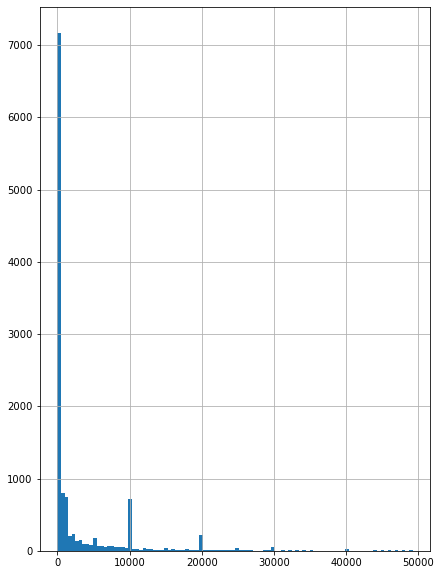

In [7]:
print(df['Standard Value'].describe())
#df['Standard Value'].hist(bins = 100, figsize = (7,10))
df['Standard Value'][df['Standard Value'] < 50000].hist(bins = 100, figsize = (7,10))
plt.show()

II.2

We remark that the range of ic50 across multiple magnitude.

Even if we zoom in to the range between 0 and 50000, the distribution of ic50 shows a clear tail-heavy shape, which is not idea for neural network to predict. 

Although there are studies related to improving regressor performance on a tail-heavy output distribution, an trivial workaround here could be apply logarithmic to the ic50 to reduce the interval of label data and reshape it into a bell-shape, which is easier to train for predictive models. 

In [8]:
df['tmp_logic50'] = np.log(df['Standard Value'])

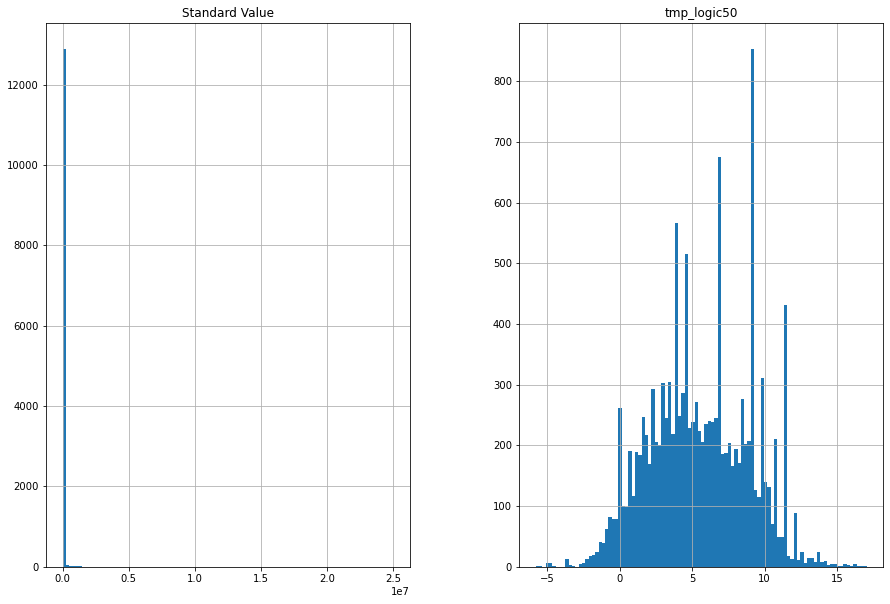

In [9]:
df[['Standard Value', 'tmp_logic50']].hist(bins = 100, figsize = (15,10))
plt.show()

After np.log() the ic50 data is in a more reasonable range and a bell-shape distribution. Several peaks are quite high comparing to its adjacent ones because there are several values are more commonly involved such as 10000nM. 

II.3

We also remark that there is one column called "Standard Relation" which contains either =, >(=), and <(=)

In [10]:
df['Standard Relation'].value_counts()

'='     10243
'>'      1960
'<'       726
'<='       82
'>>'       11
'>='        5
'~'         1
Name: Standard Relation, dtype: int64

Here, a strategic choice has to be made. The safest play is to remove all relations that is not "equal" because the value we get would not be an accurate value and are therefore toxic for the model. However, in this case, we work on a very limited amount of data, "saving" a maximum usable data is preferred. 

The strategy that I chose is: save all values with > (aka, true value > value shown in the dataset) if they are above 75% quantile of tmp_logic50m, also, save all values with < if they are below 25% quantile of tmp_logic50. 

The argument is that: if we know a candidate's true ic50 is smaller than a already small ic50 value, we can define it as "good" candidate, the only doute is whether it is "commonly good" or it is "extremly good". Same logit applies to values superior than 75% quantile as well, we know it is a bad candidate. So I chose to keep these data to enhance the performance of our predictive model.

In [11]:
ic50_quantile25 = df['tmp_logic50'].quantile(q = 0.25)

In [12]:
ic50_quantile75 = df['tmp_logic50'].quantile(q = 0.75)

In [13]:
df['tmp_logic50'].describe()

count    13028.000000
mean         5.634711
std          3.463563
min         -5.809143
25%          3.091042
50%          5.480639
75%          8.517193
max         17.034386
Name: tmp_logic50, dtype: float64

In [14]:
#Apply above described filter about relation and values.
df = df[(df['Standard Relation'].str.contains('>')) & (df['tmp_logic50'] > ic50_quantile75) 
    |(df['Standard Relation'].str.contains('<')) & (df['tmp_logic50'] < ic50_quantile25)
    |(df['Standard Relation'] == "'='")
]

In [15]:
#Exclude non-important columns
df = df[['Molecule ChEMBL ID', 'Molecular Weight', 'Smiles', 
         'Standard Type', 'Standard Relation', 'Standard Value', 
         'Standard Units','tmp_logic50']]

II.4

One other attribute we need to pay attention is the Standard Unit, different units can not be sumbit into the same dataset.

In [16]:
df['Standard Units'].value_counts()

nM         11861
ug.mL-1       63
/uM            6
Name: Standard Units, dtype: int64

We noticed that there are 3 different units used in the dataset, nM is the most commonly used so we try to convert other units into nM using molecular weight or just simple conversion.

In [17]:
nM_index = df['Standard Units'] == 'nM'
muMol_index = df['Standard Units'] == '/uM'
ugmL_index = df['Standard Units'] == 'ug.mL-1'

In [18]:
df.loc[nM_index, 'tmp_ic50'] = df.loc[nM_index, 'Standard Value']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11930 entries, 0 to 14361
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  11930 non-null  object 
 1   Molecular Weight    11930 non-null  object 
 2   Smiles              11930 non-null  object 
 3   Standard Type       11930 non-null  object 
 4   Standard Relation   11930 non-null  object 
 5   Standard Value      11930 non-null  float64
 6   Standard Units      11930 non-null  object 
 7   tmp_logic50         11930 non-null  float64
 8   tmp_ic50            11861 non-null  float64
dtypes: float64(3), object(6)
memory usage: 932.0+ KB


In [19]:
df.loc[ugmL_index, 'tmp_ic50'] = df[ugmL_index]['Standard Value'] / df[ugmL_index]['Molecular Weight'].astype(float) * 10 ** 6
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11930 entries, 0 to 14361
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  11930 non-null  object 
 1   Molecular Weight    11930 non-null  object 
 2   Smiles              11930 non-null  object 
 3   Standard Type       11930 non-null  object 
 4   Standard Relation   11930 non-null  object 
 5   Standard Value      11930 non-null  float64
 6   Standard Units      11930 non-null  object 
 7   tmp_logic50         11930 non-null  float64
 8   tmp_ic50            11924 non-null  float64
dtypes: float64(3), object(6)
memory usage: 932.0+ KB


In [20]:
df.loc[muMol_index, 'tmp_ic50'] = df.loc[muMol_index, 'Standard Value'].map(lambda x: x * 1000)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11930 entries, 0 to 14361
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Molecule ChEMBL ID  11930 non-null  object 
 1   Molecular Weight    11930 non-null  object 
 2   Smiles              11930 non-null  object 
 3   Standard Type       11930 non-null  object 
 4   Standard Relation   11930 non-null  object 
 5   Standard Value      11930 non-null  float64
 6   Standard Units      11930 non-null  object 
 7   tmp_logic50         11930 non-null  float64
 8   tmp_ic50            11930 non-null  float64
dtypes: float64(3), object(6)
memory usage: 932.0+ KB


In [21]:
#Refresh log ic50 using ic50 data with unified unit.
df['tmp_logic50'] = np.log(df['tmp_ic50'])
df = df.drop(columns =['tmp_ic50'])

II.5

Another issue could happen is that database contains duplicated molecule structure. So we give it a quick check.

In [22]:
df['Smiles'].value_counts()

COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCN1CCOCC1                      165
C#Cc1cccc(Nc2ncnc3cc(OCCOC)c(OCCOC)cc23)c1                           99
C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(OC)cc1N(C)CCN(C)C       95
CN(C)C/C=C/C(=O)Nc1cc2c(Nc3ccc(F)c(Cl)c3)ncnc2cc1O[C@H]1CCOC1        47
COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC                                    43
                                                                   ... 
CO[C@H](C)c1c(O)cc2c(c1O)C(=O)c1c(cc(O)c(O)c1O)C2=O                   1
CN1CCN(CCCNc2ncc3cc(-c4c(Cl)cccc4Cl)c(NC(=O)NCc4ccccc4)nc3n2)CC1      1
Cc1ncnc(Nc2ccc(OCc3cccc(F)c3)c(Cl)c2)c1C#Cc1ccc(CN2CCCC2)s1           1
C=CC(=O)Nc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCCNC(=O)CN1CCN(C)CC1          1
COc1ccc(-n2cnc3ccc(-c4nnc(SCc5cccc(C#N)c5)o4)cc32)cc1                 1
Name: Smiles, Length: 7681, dtype: int64

We noticed that there indeed has several smiles are duplicated. 

NOTE: Checking molecule duplicates by simply comparing smiles is a choice of simplicity. The rigorous strategy should be either 1) convert all smiles into rdkit mol object and then compare their Tanimoto distance, or 2) convert all smiles into cononical smiles and then compare smiles. 

In fact if we check the number of duplicates, it is quite significant.

In [23]:
len(df['Smiles'])-len(df['Smiles'].drop_duplicates())

4249

Also, if we look into the Standard Value of the same smiles, they could vary a lot.

In [24]:
df[df['Smiles'] == 'C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(OC)cc1N(C)CCN(C)C'].head()

,Molecule ChEMBL ID,Molecular Weight,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,tmp_logic50
269,CHEMBL3353410,499.62,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,IC50,'=',15000.0,nM,9.615805
294,CHEMBL3353410,499.62,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,IC50,'=',1.2,nM,0.182322
297,CHEMBL3353410,499.62,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,IC50,'=',0.9,nM,-0.105361
587,CHEMBL3353410,499.62,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,IC50,'=',142.1,nM,4.956531
801,CHEMBL3353410,499.62,C=CC(=O)Nc1cc(Nc2nccc(-c3cn(C)c4ccccc34)n2)c(O...,IC50,'=',408.5,nM,6.012492


My strategy here is to group data by smiles, compute the average of "log ic50" (not Standard Value because log(a+b) != log(a)+log(b), averaging Standard Value will make data lean to the high value end) and then select data if their standard deviation is NaN (no duplicates) or is less than 75% quantile of all std values. In another word, we eliminate top 25% of the most inconsistent data. 

In [25]:
mean_df = df.groupby([
    'Smiles', 
    'Standard Type',
    #'Standard Relation',
    #'Standard Units',
    'Molecule ChEMBL ID', 
    'Molecular Weight', 
], as_index=False).mean().drop(columns = ['Standard Value'])

In [26]:
std_df = df.groupby([
    'Smiles', 
    'Standard Type',
    #'Standard Relation',
    #'Standard Units',
    'Molecule ChEMBL ID', 
    'Molecular Weight', 
], as_index=False).std().drop(columns = ['Standard Value'])

In [27]:
mean_df[mean_df['Smiles'] == 'O=CN/C=C/c1cc(O)ccc1O']

,Smiles,Standard Type,Molecule ChEMBL ID,Molecular Weight,tmp_logic50
7354,O=CN/C=C/c1cc(O)ccc1O,IC50,CHEMBL47986,179.18,8.040209


In [28]:
df[df['Smiles'] == 'Brc1cccc(Nc2ncnc3cc4c(cc23)OCCSCCO4)c1']

,Molecule ChEMBL ID,Molecular Weight,Smiles,Standard Type,Standard Relation,Standard Value,Standard Units,tmp_logic50
9268,CHEMBL2087357,418.32,Brc1cccc(Nc2ncnc3cc4c(cc23)OCCSCCO4)c1,IC50,'=',7.0,nM,1.94591


In [29]:
mean_df.head()

,Smiles,Standard Type,Molecule ChEMBL ID,Molecular Weight,tmp_logic50
0,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1ccc(C(...,IC50,CHEMBL1914657,479.30,8.435549
1,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1cccc2c...,IC50,CHEMBL1914666,461.36,6.915723
2,Br.CC[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1...,IC50,CHEMBL1914665,425.33,1.386294
3,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,IC50,CHEMBL1914655,490.20,4.127134
4,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,IC50,CHEMBL1914654,429.29,1.335001


In [30]:
std_df.head()

,Smiles,Standard Type,Molecule ChEMBL ID,Molecular Weight,tmp_logic50
0,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1ccc(C(...,IC50,CHEMBL1914657,479.30,NaN
1,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1cccc2c...,IC50,CHEMBL1914666,461.36,NaN
2,Br.CC[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1...,IC50,CHEMBL1914665,425.33,NaN
3,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,IC50,CHEMBL1914655,490.20,NaN
4,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,IC50,CHEMBL1914654,429.29,NaN


In [31]:
std_df['tmp_logic50'].dropna().describe()

count    2278.000000
mean        1.315690
std         1.179979
min         0.000000
25%         0.248739
50%         1.113837
75%         2.046835
max         7.109471
Name: tmp_logic50, dtype: float64

In [32]:
std_quantile75 = std_df['tmp_logic50'].quantile(q = 0.75)

In [33]:
cleaned_df = mean_df[(std_df['tmp_logic50'].isnull()) | (std_df['tmp_logic50'] < std_quantile75)]

In [34]:
cleaned_df = cleaned_df.rename(columns = {'tmp_logic50': 'log_ic_50'})

In [35]:
cleaned_df

,Smiles,Standard Type,Molecule ChEMBL ID,Molecular Weight,log_ic_50
0,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1ccc(C(...,IC50,CHEMBL1914657,479.30,8.435549
1,Br.CC(Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1cccc2c...,IC50,CHEMBL1914666,461.36,6.915723
2,Br.CC[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1...,IC50,CHEMBL1914665,425.33,1.386294
3,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,IC50,CHEMBL1914655,490.20,4.127134
4,Br.C[C@@H](Nc1ncnc2[nH]c(-c3ccc(O)cc3)cc12)c1c...,IC50,CHEMBL1914654,429.29,1.335001
...,...,...,...,...,...
7675,c1cncc(Cn2ncc3cc(Nc4ncnn5ccc(COC[C@@H]6CNCCO6)...,IC50,CHEMBL247127,470.54,6.697034
7676,c1coc(-c2nnc(Cc3nc4ccccc4[nH]3)o2)c1,IC50,CHEMBL4061912,266.26,11.512925
7677,c1csc(-c2cc3nccc(Nc4ccc5[nH]ccc5c4)c3s2)c1,IC50,CHEMBL310853,347.47,0.000000
7679,c1csc(-c2nnc(Cc3nc4ccccc4[nH]3)o2)c1,IC50,CHEMBL4075892,282.33,11.512925


As a summary, if we simply remove all duplicates, remove all unit inconsistency, remove all "<" and ">" relation value, remove all duplicates because we don't know which data to believe, we are expected to get a dataset around 3000 data. With reasonable conservation and manipulation, we have conserved 7111 data in total.

# Part III. Data transformation 

Now we have our data with:
- Relation(=, >, <) handled
- Unit unified
- Duplicates removed
- Value averaged for duplicates
- Inconsistent data removed

Let's take a look how it looks like

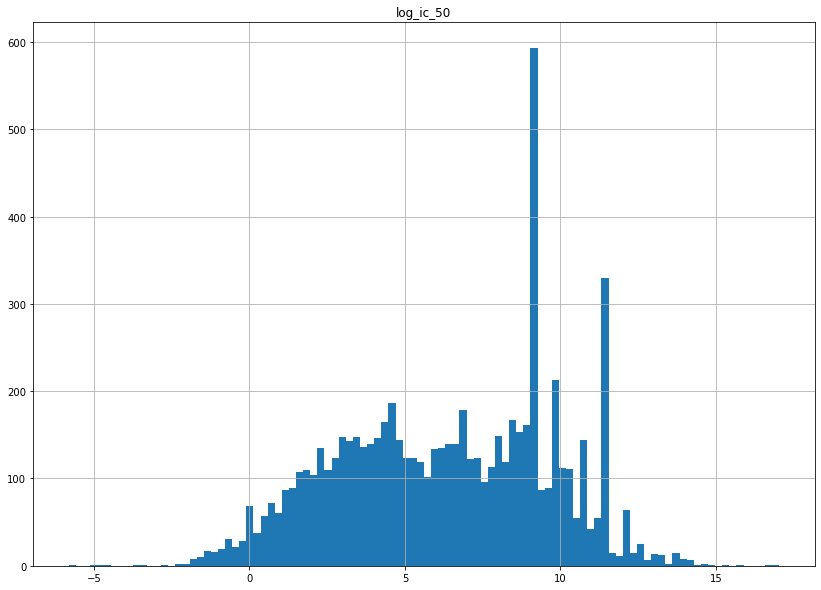

In [36]:
cleaned_df[['log_ic_50']].hist(figsize = (14, 10), bins = 100)
plt.show()

We then split this cleaned data set into training and testing set and convert into different format for different models.

In [37]:
train, test = train_test_split(cleaned_df, test_size=0.2)

In [38]:
#For GNN affinity predictor
train[['Smiles','log_ic_50']].to_csv('erbb1_logic50_data_train.txt', sep=" ", header = False, index = None)
test[['Smiles','log_ic_50']].to_csv('erbb1_logic50_data_test.txt', sep=" ", header = False, index = None)

In [39]:
#For SAMPN
cleaned_df[['Smiles', 'log_ic_50']].to_csv('erbb1_log_50.csv', sep = ',', header = False, index = None)

In [40]:
#For ChemTS
cleaned_df[['Smiles']].to_csv('erbb1_ligand.csv', sep = ',', header = False, index = None)

In [41]:
#===============End=====================